# Feature Engineering

"Feature engineering is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data."
Jason Brownlee, [Machine Learning Mastery](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/)

You can construct new features out of existing features, select features the best features, remove the worst features, penalize features by giving them no weight in the model, transform features, as examples. 

Some feature engineering methods include:  

- Construct new features: Use domain knowledge, creating products of features, etc. 

- Use statistical tests to determine each feature's usefulness in predicting the target variable. Rank the features and then select the K best features (Select K Best). 

- Recursively remove attributes to meet the number of required features and then build a model on those attributes that remain to see if you can you match or improve performance with a smaller subset (Recursive Feature Elimination).   
- Recursively remove the worst performing features one by one till the overall performance of the model comes in acceptable range (Backward Elimination).  

- Add features one at a time beginning with the predictor with the highest correlation with the dependent variable. Variables of greater theoretical importance are entered first. Once in the equation, the variable remains there (Forward Selection). 

- many, many more...(see appendix for more such as PCA and regularization). 

**For the feature engineering methods with regression, we want to use the scaled data**

## The Short Lesson

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import env

import warnings
warnings.filterwarnings("ignore")

In [2]:
def train_validate_test(df, target):
    '''
    this function takes in a dataframe and splits it into 3 samples, 
    a test, which is 20% of the entire dataframe, 
    a validate, which is 24% of the entire dataframe,
    and a train, which is 56% of the entire dataframe. 
    It then splits each of the 3 samples into a dataframe with independent variables
    and a series with the dependent, or target variable. 
    The function returns 3 dataframes and 3 series:
    X_train (df) & y_train (series), X_validate & y_validate, X_test & y_test. 
    '''
    # split df into test (20%) and train_validate (80%)
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)

    # split train_validate off into train (70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

        
    # split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train.drop(columns=[target])
    y_train = train[target]
    
    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    
    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test.drop(columns=[target])
    y_test = test[target]
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test

def get_numeric_X_cols(X_train, object_cols):
    '''
    takes in a dataframe and list of object column names
    and returns a list of all other columns names, the non-objects. 
    '''
    numeric_cols = [col for col in X_train.columns.values if col not in object_cols]
    
    return numeric_cols


def min_max_scale(X_train, X_validate, X_test, numeric_cols):
    '''
    this function takes in 3 dataframes with the same columns, 
    a list of numeric column names (because the scaler can only work with numeric columns),
    and fits a min-max scaler to the first dataframe and transforms all
    3 dataframes using that scaler. 
    it returns 3 dataframes with the same column names and scaled values. 
    '''
    # create the scaler object and fit it to X_train (i.e. identify min and max)
    # if copy = false, inplace row normalization happens and avoids a copy (if the input is already a numpy array).


    scaler = MinMaxScaler(copy=True).fit(X_train[numeric_cols])

    #scale X_train, X_validate, X_test using the mins and maxes stored in the scaler derived from X_train. 
    # 
    X_train_scaled_array = scaler.transform(X_train[numeric_cols])
    X_validate_scaled_array = scaler.transform(X_validate[numeric_cols])
    X_test_scaled_array = scaler.transform(X_test[numeric_cols])

    # convert arrays to dataframes
    X_train_scaled = pd.DataFrame(X_train_scaled_array, 
                                  columns=numeric_cols).\
                                  set_index([X_train.index.values])

    X_validate_scaled = pd.DataFrame(X_validate_scaled_array, 
                                     columns=numeric_cols).\
                                     set_index([X_validate.index.values])

    X_test_scaled = pd.DataFrame(X_test_scaled_array, 
                                 columns=numeric_cols).\
                                 set_index([X_test.index.values])

    
    return X_train_scaled, X_validate_scaled, X_test_scaled



In [3]:
def create_dummies(df, object_cols):
    '''
    This function takes in a dataframe and list of object column names,
    and creates dummy variables of each of those columns. 
    It then appends the dummy variables to the original dataframe. 
    It returns the original df with the appended dummy variables. 
    '''
    
    # run pd.get_dummies() to create dummy vars for the object columns. 
    # we will drop the column representing the first unique value of each variable
    # we will opt to not create na columns for each variable with missing values 
    # (all missing values have been removed.)
    dummy_df = pd.get_dummies(object_cols, dummy_na=False, drop_first=True)
    
    # concatenate the dataframe with dummies to our original dataframe
    # via column (axis=1)
    df = pd.concat([df, dummy_df], axis=1)

    return df

In [4]:
def get_object_cols(df):
    '''
    This function takes in a dataframe and identifies the columns that are object types
    and returns a list of those column names. 
    '''
    # create a mask of columns whether they are object type or not
    mask = np.array(df.dtypes == "object")

        
    # get a list of the column names that are objects (from the mask)
    object_cols = df.iloc[:, mask].columns.tolist()
    
    return object_cols
    

In [5]:
def wrangle_student_math(path):
    df = pd.read_csv(path, sep=";")
    
    # drop any nulls
    df = df[~df.isnull()]

    # get object column names
    object_cols = get_object_cols(df)
    
    # create dummy vars
    df = create_dummies(df, object_cols)
      
    # split data 
    X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df, 'G3')
    
    # get numeric column names
    numeric_cols = get_numeric_X_cols(X_train, object_cols)

    # scale data 
    X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, X_validate, X_test, numeric_cols)
    
    return df, X_train, X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test

In [6]:
# Here's the source for the dataset and data dictionary https://archive.ics.uci.edu/ml/datasets/student+performance
path = "https://gist.githubusercontent.com/ryanorsinger/55ccfd2f7820af169baea5aad3a9c60d/raw/da6c5a33307ed7ee207bd119d3361062a1d1c07e/student-mat.csv"

df, X_train_explore, \
    X_train_scaled, y_train, \
    X_validate_scaled, y_validate, \
    X_test_scaled, y_test = wrangle_student_math(path)

In [7]:
X_train_explore.shape

(221, 48)

In [8]:
# Drop any nulls
X_train_explore = X_train_explore.dropna(axis=1)
X_train_scaled = X_train_scaled.dropna(axis=1)

In [9]:
X_train_explore.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
142,GP,F,15,U,GT3,T,4,4,teacher,services,...,no,4,2,2,1,1,5,2,9,11
326,GP,M,17,U,GT3,T,3,3,other,services,...,no,4,3,5,3,5,5,3,14,15
88,GP,M,16,U,GT3,T,2,2,services,other,...,no,4,4,2,1,1,3,12,11,10
118,GP,M,17,R,GT3,T,1,3,other,other,...,no,5,2,4,1,4,5,20,9,7
312,GP,M,19,U,GT3,T,1,2,other,services,...,no,4,5,2,2,2,4,3,13,11


### SelectKBest

Select the K best features using a statistical test to compare each X with y and find which X's have the strongest relationship with y. For regression, we will use the correlation test (`f-regression`) to score the relationships. 

1. Initialize the f_selector object, setting the parameters, or instructions for the method to follow: "use the *f_regression* test for scoring the features, and return to me the top *10* features", for example. 
2. Fit the object to our data. That is, run a correlation test for every X variable with our y variable, and then rank the X variables based on how correlated they are with the y/target variable. Then give me the top *10* features. 
3. Use get_support() to get the list of features, and save them to a variable that you can use to filter your dataframe in modeling. 

In [10]:
X_train_scaled.columns.tolist()

['age',
 'Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences',
 'G1',
 'G2']

In [11]:
from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 8 features
f_selector = SelectKBest(f_regression, k=14)

# find the top 8 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

In [12]:
# boolean mask is a name for an array of booleans
feature_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True])

In [13]:
# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [14]:
f_feature

['age',
 'Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'famrel',
 'freetime',
 'goout',
 'Walc',
 'health',
 'absences',
 'G1',
 'G2']

## Now we know
- k of 1 says G2 (midterm)
- k of 2 says G1 and G2 midterm
- k of 3 says failures, G1 and G2
- k4 adds Maternal educational background
- k5 is ['Medu', 'Fedu', 'failures', 'G1', 'G2']
- k6 is ['age', 'Medu', 'Fedu', 'failures', 'G1', 'G2']
- k7 is ['age', 'Medu', 'Fedu', 'traveltime', 'failures', 'G1', 'G2']
- k8 is ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'G1', 'G2']

### Recursive Feature Elimination

Recursive Feature Elimination will create a model with all the features, evaluate the performance metrics, find the weakest feature, remove it, then create a new model with the remaining features, evaluate the performance metrics, find the weakest feature, remove it, and so on, until it gets down to the number of features you have indicated you want when creating the rfe object. You will also indicate which Machine Learning algorithm you want to use. 

1. Initialize the machine learning algorithm, in this case LinearRegression
2. Initialize the RFE object, and provide the ML algorithm object from step 1
3. Fit the RFE object to our data. Doing this will provide us a list of features (the number we asked for) as well as a ranking of all the features. 
4. Assign the list of selected features to a variable. 
5. Optional: Get ranking of all variables (1 being most important)

<AxesSubplot:xlabel='G2', ylabel='G3'>

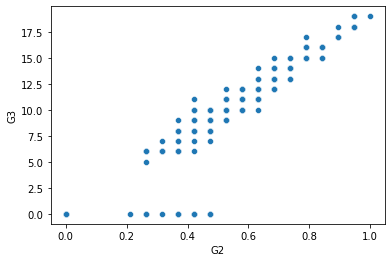

In [15]:
# Let's make sure there's a linear relationship between the feature(s) and the target
import seaborn as sns
sns.scatterplot(x="G2", y=y_train, data=X_train_scaled)

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, 2)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [17]:
rfe_feature

['G1', 'G2']

In [18]:
# view list of columns and their ranking

# get the ranks
var_ranks = rfe.ranking_

# get the variable names
var_names = X_train_scaled.columns.tolist()

# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})

# sort the df by rank
rfe_ranks_df.sort_values('Rank')

,Var,Rank
13,G1,1
14,G2,1
12,absences,2
0,age,3
6,famrel,4
3,traveltime,5
11,health,6
5,failures,7
1,Medu,8
9,Dalc,9


## The Longer Lesson 

This part of the lesson goes through what we just covered above, but with more depth. 

### Select K Best 

The goal of filter methods, such as SelectKBest, is to keep the attributes with highest correlation to the target variable and of those features, if two are highly correlated with each other, remove one of them. With filter methods, the model is built after selecting the features. These methods identify the relevant features and subset the data with only those features. 

Select K Best is a filter method, meaning the goal is to find and keep the attributes with highest correlation to the target variable and of those features, if two are highly correlated with each other, remove one of them. 

`SelectKBest` will identify the K most relevant features and subset the data with only those features. Relevancy is determined by the the test statistic for the chosen function or test (Chi-squared, F-regression, etc.). For regression, we will use the f-regression test to score the individual effect of each of the features (aka regressors). 

In [19]:
from sklearn.feature_selection import SelectKBest, f_regression

1. Initialize the f_selector object, setting the parameters, or instructions for the method to follow: "use the f_regression test for scoring the features, and return to me the top 10 features", for example.

In [20]:
f_selector = SelectKBest(f_regression, k=2)

2. Fit the object to our data. In doing this, our selector is scoring, ranking, and identifying the top `k` features. 

In [21]:
f_selector.fit(X_train_scaled, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x12276fe18>)

3. Transform our dataset to reduce to the `k` best features. 

In [22]:
X_reduced = f_selector.transform(X_train_scaled)

print(X_train_scaled.shape)
print(X_reduced.shape)

(221, 15)
(221, 2)


We can simplify steps 1-3 in the following way: 

In [23]:
X_reduced2 = SelectKBest(f_regression, k=2).fit_transform(X_train_scaled, y_train)
print(X_reduced2.shape)

(221, 2)


We can use the `inverse_transform` function to return to the original variables. 

Let's say we want a list of the features we have selected. Why? Maybe we want to run various feature selection methods and want to keep track of how many times each feature was selected. We could simply grab the column names from our new dataframe above that contains only the best 2 features. However, maybe we don't need the new dataframe yet, as we aren't quite sure which features we will finally decide to keep. In that case, we would create the object using `SelectKBest`, `fit` it to the data (not transform), and then we could use `get_support` to get a mask, or integer index, of the features the algorithm selected. 

Let's walk through that. 
You will see below we end up with a list of booleans that relate to the feature indices. 

In [24]:
f_support = f_selector.get_support()

print(f_support) 

[False False False False False False False False False False False False
 False  True  True]


We get a list of the feature names selected from X_train using `.loc` with our mask, using `.columns` to get the column names, and convert the values to a list using `.tolist()`. 

In [25]:
f_feature = X_train_scaled.loc[:,f_support].columns.tolist()

# you could also get the list this way (among many others)
# f_feature = [X_train_scaled.columns.values[i] for i in range(len(feature_mask)) if feature_mask[i]==True]

print(str(len(f_feature)), 'selected features')
print(f_feature)

2 selected features
['G1', 'G2']


To summarize, we used the `SelectKBest` method to select the top `k` features, and these features are scored and ranked using a statistical test, which we used the f-regression test in this case.

### Recursive Feature Elimination

Recursive Feature Elimination is a wrapper method for feature selection. This means that it works by using the output of a machine learning algorithm as the evaluation criteria for eliminating features; in the case of linear regression, it uses the resulting coefficients.

You feed all the features to the selected Machine Learning algorithm, and, based on the the hyperparameters you have set, features are removed. One word of caution...this is an iterative and computationally expensive process! The pro is that it is more accurate than SelectKBest. 

RFE recursively removes attributes and then builds a model on those attributes that remain. The RFE method takes the machine learning algorithm to be used and the number of required features as input. It returns the ranking of all the variables, 1 being most important, along with its support: a list of boolean values, True indicating relevant features and False indicating irrelevant features.

These are the steps we will take to implement RFE:  

1. Initialize the linear regression object. `sklearn.linear_model.LinearRegression`  
2. Initialize the RFE object. `sklearn.feature_selection.RFE`  
3. Fit the RFE object to our data. `rfe.fit()`  
4. Transform our X dataframe to include only those 2 features. `rfe.transform()`  
5. Optional: Get list of features selected  
6. Optional: Get ranking of all variables  

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

1. Initialize the linear regression object

In [27]:
lm = LinearRegression()

2. Initialize the RFE object, setting the hyperparameters to be our linear regression object created above (as the algorithm to test the features on) and the number of features to return to be 2.   

In [28]:
rfe = RFE(lm, 2)

3. Fit the RFE object to our data. This means create multiple linear regression models, find the one that performs best, and identify the features that are used in that model. Those are the features we want.   
4. Transform our X dataframe to include only those 2 features. `.transform()` *or do both of those steps together with `.fit_transform()`*

In [29]:
# Transforming data using RFE
X_rfe = rfe.fit_transform(X_train_scaled,y_train)  

When we move on to modeling, we would then use our new X dataframe as the one to move forward for actual modeling. As a sneak peak...

In [30]:
#Fitting the data to model
lm.fit(X_rfe,y_train)

LinearRegression()

5. If we want a list of the features that remain, we can use `.support_` similar to how we used `.get_support()` with `SelectKBest`. 

In [31]:
mask = rfe.support_

In [32]:
rfe_features = X_train_scaled.loc[:,mask].columns.tolist()

In [33]:
print(str(len(rfe_features)), 'selected features')
print(rfe_features)

2 selected features
['G1', 'G2']


6. We can also get a ranking of the features using `rfe.ranking_`. This will return a 1 for the features that were selected. So, since we said we wanted 2 features to remain, the top two features will have a rank of 1. The features that were eliminated will be ranked accordingly. In this case, the third feature will have a rank of 2. However, if we had more than 1 feature that was eliminated, they would all have different ranks. 

In [34]:
var_ranks = rfe.ranking_
var_names = X_train_scaled.columns.tolist()

pd.DataFrame({'Var': var_names, 'Rank': var_ranks})

,Var,Rank
0,age,3
1,Medu,8
2,Fedu,12
3,traveltime,5
4,studytime,14
5,failures,7
6,famrel,4
7,freetime,13
8,goout,10
9,Dalc,9


Here we took LinearRegression model with 2 features and RFE gave feature ranking as above, but the selection of number ‘2’ was random. If you would like to learn how to find the optimum number of features, for which the accuracy is the highest, see the extended lesson in the appendix of ds.codeup.com.  

## Summary

- We used SelectKBest to select the top 2 features based on how correlated each feature is with the target variable. We ended up with exam1 and exam3.    
- We use RFE and a linear regression algorithm to keep the top 2 features based on which features lead to the best performing linear regression model. This eliminated exam2 and also left us with exam1 and exam3, like SelectKBest. 